# 数据读取

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency,pointbiserialr
from scipy.stats.contingency import association
import plotly.express as px
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from scipy.stats import beta
from statsmodels.stats.proportion import proportion_confint
from collections import Counter
import xgboost as xgb
# from tqdm import tqdm  # 用 tqdm 代替 tqdm.autonotebook.tqdm
import shap
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 


file_path = r"D:\兼职\兼职\作品项目\coupons.csv"
df = pd.read_csv(file_path, engine='python')
data = df.copy()
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


# 数据探索性分析

在数据下载的网站已经提供了数据行数、字段数和含义解释。接下来需要验证下拿到手的数据集是否符合描述。

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [3]:
data.shape

(12684, 26)

数据大小和网站描述一致，接下来要对数据进行探索性分析。以及观察到有些字段存在数据缺失的情况，尽管网站写的是Missing Values is no……比如car字段缺失较多，接下来数据清洗时可以删除。

## 数据效度

因为不适用于信度检验的方式，所以只能对问卷数据进行一些效度检验。比如结构性：是否充分涵盖了多种类型？结果上是否只偏向一种结果？（虽然可能符合实际情况，但是不利于全面的分析）

In [4]:
y = data['Y'].value_counts()

px.bar(x = y.index , y = y, title = 'Y Value', width = 600, height = 400, color = y.index)

1:0=7210:5474
结果分布是不平衡的。但是差距不是非常巨大，而且0的数据量也较大，接下来要看各可能影响因素的结构分布情况，能否包含全面的信息

In [8]:
# 为了方便理解分析，将华氏度转为摄氏度
data['temperature'] = ((data['temperature'] - 32) * (5 / 9)).round(2)


In [9]:
object_cols = data.columns.to_list()

# 定义子图行列数
cols = 4
rows = (len(object_cols) - 1) // cols + 1

obj = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=object_cols,
    specs=[[{'type': 'domain'} for _ in range(cols)] for _ in range(rows)]  
)


for index, col in enumerate(object_cols):
    labels = data[col].value_counts().index
    values = data[col].value_counts().values
    row = index // cols + 1 
    col_ = index % cols + 1

    obj.add_trace(
        go.Pie(labels=labels, values=values, name=col),
        row=row, col=col_
    )

obj.update_layout(height=2000, width=1000, title_text="分布饼图")
obj.show()

好的，对于各字段进行分析，看接下来应该如何清洗数据：
1. 对于destination这个字段，no urgent place 占了一半。凭经验感知，或许和实际情况偏差较大。
2. occupayion 细分类过多，需要整合
3. car 数据量缺失严重，需要drop
4. 其余各类型分布较合理。因为问卷对象是美国人，和中国人口结构、收入水平、社会结构差距较大。

### Summary for 数据效度：
1. destination 字段效度存疑
2. 整体略不平衡，但可能反映了实际情况，而且差别不大，各群体样本量也较为充足。
3. 后续对occupayion  和 car  进行进一步处理。
4. 对于空值、重复值进行处理
5. 为了方便业务分析，对于数值型数据打标签
### SO 数据可用

## 数据清洗

In [10]:
## 重复值
data.drop_duplicates()
print('重复数据 ' + str(data.duplicated().sum())  )

## drop car
data = data.drop(columns = 'car')

## 空值处理
## 根据之前的观察，只有这几个字段有缺失

print(
(data.shape[0] - data[['CoffeeHouse',
                          'Restaurant20To50',
                          'CarryAway',
                          'RestaurantLessThan20',
                          'Bar']].isnull().sum()).sort_values(ascending=False))
print('需要删除的行 ' + str(data.shape[0] - data.dropna().shape[0]) )

print('占比 ' + str(np.round((1 - (data.dropna().shape[0] / data.shape[0])) * 100, 2)) + ' %' )

data = data.dropna()


print('删除后空值数' +  str(data.isnull().sum()))

## occupayion 整合

occupation_mapping = {
    'Computer & Mathematical': 'Technical engineering',
    'Architecture & Engineering': 'Technical engineering',
    'Life Physical Social Science': 'Technical engineering',
    'Sales & Related': 'Business Management',
    'Management': 'Business Management',
    'Office & Administrative Support': 'Business Management',
    'Business & Financial': 'Business Management',
    'Food Preparation & Serving Related': 'Social service',
    'Healthcare Support': 'Social service',
    'Transportation & Material Moving': 'Social service',
    'Building & Grounds Cleaning & Maintenance': 'Social service',
    'Education&Training&Library': 'Public affairs',
    'Healthcare Practitioners & Technical': 'Public affairs',
    'Community & Social Services': 'Public affairs',
    'Legal': 'Public affairs',
    'Protective Service': 'Public affairs',
    'Arts Design Entertainment Sports & Media': 'Creative industries',
    'Personal Care & Service': 'Creative industries',
    'Construction & Extraction': 'Basic industries',
    'Installation Maintenance & Repair': 'Basic industries',
    'Production Occupations': 'Basic industries',
    'Farming Fishing & Forestry': 'Basic industries',
    'Unemployed': 'Inactive employment',
    'Student': 'Inactive employment',
    'Retired': 'Inactive employment'
}

data['occupation'] = data['occupation'].replace(occupation_mapping)

print('occupation修改后分布：'+ str(data['occupation'].value_counts()))

## has_children
has_children_mapping = {
    1: 'has_children',
    0: 'no_children'
    }
data['has_children'] = data['has_children'].replace(has_children_mapping)

print('has_children修改后分布：'+ str(data['has_children'].value_counts()))

conditions = [
    data['toCoupon_GEQ15min'] == 0,
    (data['toCoupon_GEQ15min'] == 1) & (data['toCoupon_GEQ25min'] == 0),
    data['toCoupon_GEQ25min'] == 1
]

choices = ['short', 'medium', 'long']

data['toCoupon_time'] = np.select(conditions, choices, default='unknown')

print('toCoupon_time修改后分布：'+ str(data['toCoupon_time'].value_counts()))

重复数据 74
Bar                     12577
RestaurantLessThan20    12554
CarryAway               12533
Restaurant20To50        12495
CoffeeHouse             12467
dtype: int64
需要删除的行 605
占比 4.77 %
删除后空值数destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64
occupation修改后分布：Inactive employment      3784
Business Management      2977
Technical engineering    1713
Public affairs           1690
Soc

# 找出影响使用优惠券的关键特征，用于优化优惠券策略

### 单因素使用转化率分析

In [11]:

# 判断变量与目标变量是否相关（卡方检验）
def check_correlation(data, col, target_col):
    contingency = pd.crosstab(data[col], data[target_col])
    res = chi2_contingency(contingency)
    print(f"{col} - {target_col}:", '相关' if res[1] < 0.05 else '不相关', f"p值={res[1]:.4f}")

# 计算每个类别变量的正样本转化率
def probability(data, col, target_col='Y'):    
    yes_counts = data[data[target_col] == 1][col].value_counts()
    total_counts = data[col].value_counts()
    ratio_yes = (yes_counts / total_counts).fillna(0) * 100
    # 排序
    ratio_yes = ratio_yes.sort_values(ascending=False)    
    return ratio_yes.index.astype(str), ratio_yes.values  # x 和 y 分别返回

clran_cols = data.columns.to_list()

# 创建 subplot
bar = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=clran_cols,
    specs=[[{'type': 'bar'} for _ in range(cols)] for _ in range(rows)]
)

# 绘制图表 + 打印卡方检验结果
for i, col in enumerate(clran_cols):
    row = i // cols + 1
    col_ = i % cols + 1
    
    x_vals, y_vals = probability(data, col, 'Y')

    bar.add_trace(
        go.Bar(x=x_vals, y=y_vals, name=col, text=[f"{v:.2f}%" for v in y_vals], textposition='auto'),
        row=row,
        col=col_
    )
    
    check_correlation(data.copy(), col, 'Y')

bar.update_layout(height=500 * rows, width=1000, title_text="分类变量的转化率 & 相关性分析")
bar.show()

destination - Y: 相关 p值=0.0000
passanger - Y: 相关 p值=0.0000
weather - Y: 相关 p值=0.0000
temperature - Y: 相关 p值=0.0000
time - Y: 相关 p值=0.0000
coupon - Y: 相关 p值=0.0000
expiration - Y: 相关 p值=0.0000
gender - Y: 相关 p值=0.0000
age - Y: 相关 p值=0.0000
maritalStatus - Y: 相关 p值=0.0000
has_children - Y: 相关 p值=0.0000
education - Y: 相关 p值=0.0000
occupation - Y: 相关 p值=0.0011
income - Y: 相关 p值=0.0000
Bar - Y: 相关 p值=0.0000
CoffeeHouse - Y: 相关 p值=0.0000
CarryAway - Y: 相关 p值=0.0000
RestaurantLessThan20 - Y: 相关 p值=0.0006
Restaurant20To50 - Y: 相关 p值=0.0000
toCoupon_GEQ5min - Y: 不相关 p值=1.0000
toCoupon_GEQ15min - Y: 相关 p值=0.0000
toCoupon_GEQ25min - Y: 相关 p值=0.0000
direction_same - Y: 不相关 p值=0.1197
direction_opp - Y: 不相关 p值=0.1197
Y - Y: 相关 p值=0.0000
toCoupon_time - Y: 相关 p值=0.0000


一些很有意思的发现，甚至违反了认知：
1. direction_same和direction_opp 竟然和结果无关……可能是由于，如果消费场所位置距离较近，那么即便方向不同也不影响决策。后续可根据分析结果，考虑是否进行深入研究。
2. 对于各类场所never的人群，转化率也有50%左右。

找出组合明显有效的特征

destination
passanger
weather
temperature
time
coupon
expiration
gender
age
maritalStatus
has_children
education
occupation
income
toCoupon_time

经过前面的有效性分析和整体关联要避免场所细分，初步筛选的特征。因为存在一些违反认知的结果，所以判断每个因素对接受率的影响方向和影响度。

In [12]:
all_features = ['destination',
'passanger',
'weather',
'temperature',
'time',
'expiration',
'gender',
'age',
'maritalStatus',
'has_children',
'education',
'occupation',
'income',
'toCoupon_time'
]
# 只保留这些特征 + 标签列
data_all_features= data[all_features + ['Y']].dropna()

📊 模型评估报告：
              precision    recall  f1-score   support

           0     0.5564    0.4104    0.4724      1021
           1     0.6380    0.7606    0.6939      1395

    accuracy                         0.6126      2416
   macro avg     0.5972    0.5855    0.5831      2416
weighted avg     0.6035    0.6126    0.6003      2416

Accuracy : 0.6126
Precision: 0.6380
Recall   : 0.7606

🎯 每个特征项对接收优惠券的影响方向（前部分）:
| feature                          |     coef | impact   |
|:---------------------------------|---------:|:---------|
| cat__education_Some High School  | 0.518818 | 正向     |
| cat__passanger_Friend(s)         | 0.323237 | 正向     |
| cat__expiration_1d               | 0.316338 | 正向     |
| cat__weather_Sunny               | 0.30646  | 正向     |
| cat__age_below21                 | 0.250567 | 正向     |
| cat__destination_No Urgent Place | 0.235569 | 正向     |
| cat__maritalStatus_Single        | 0.230768 | 正向     |
| cat__toCoupon_time_short         | 0.217475 | 正向     |
| cat__oc

D:\Anaconda\data\lib\site-packages\pandas\compat\_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\data\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



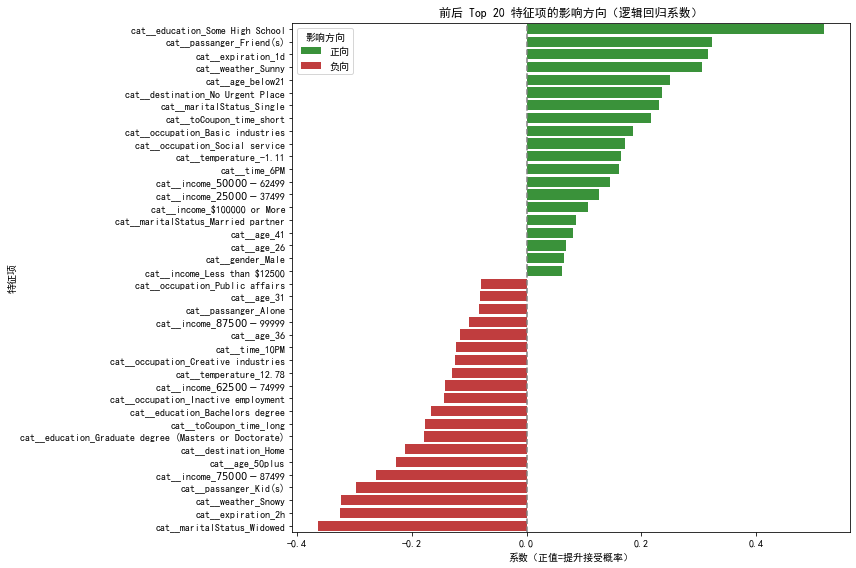

In [14]:
def analyze_logistic_feature_impact(X, y, top_k=20, random_state=42):
    """逻辑回归：分析特征对接受优惠券的正负影响"""
    
    # 自动识别分类特征
    cat_cols = X.columns.tolist()  

    # OneHot 编码 + passthrough
    preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop=None, sparse=False), cat_cols)
])

    # 构建 pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # 拆分训练测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # 拟合训练集
    pipeline.fit(X_train, y_train)

    # 模型评估
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    print("📊 模型评估报告：")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")

    # 用全部数据重新拟合模型（获取更稳定的系数）
    pipeline.fit(X, y)

    # 取出特征名 + 系数
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
#     print("特征数：" + str(len(feature_names)))
#     # 打印分类变量数量
#     print(f"分类变量（object）列数: {len(cat_cols)}")
#     print(f"预处理后特征数: {len(feature_names)}")
#     print("预处理后特征名示例:", feature_names[:10])


    coef = pipeline.named_steps['classifier'].coef_[0]

    feature_effect = pd.DataFrame({
        'feature': feature_names,
        'coef': coef,
        'impact': np.where(coef > 0, '正向', '负向')
    }).sort_values('coef', ascending=False)
    
    
    print("\n🎯 每个特征项对接收优惠券的影响方向（前部分）:")
    print(feature_effect.head(10).to_markdown(index=False))

    # 取前后 top_k 个影响最大的特征
    top_features = pd.concat([
        feature_effect.head(top_k),
        feature_effect.tail(top_k)
    ])

    # 可视化
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='coef', y='feature', hue='impact',
        data=top_features,
        dodge=False, palette={'正向': '#2ca02c', '负向': '#d62728'}
    )
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"前后 Top {top_k} 特征项的影响方向（逻辑回归系数）")
    plt.xlabel("系数（正值=提升接受概率）")
    plt.ylabel("特征项")
    plt.legend(title='影响方向')
    plt.tight_layout()
    plt.show()

    return feature_effect

# 特征和标签
X = data_all_features[all_features]
y = data_all_features['Y']

feature_effect = analyze_logistic_feature_impact(
    X=data_all_features[all_features],
    y=data_all_features['Y'],
    top_k=20
)

In [29]:
feature_effect.to_excel(r"D:\兼职\兼职\作品项目\feature_effect.xlsx", index=False)

distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


对于单因素，正向影响最大的是：
cat__education_Some High School

负向影响最大的是：
cat__expiration_2h


接下来基于改进FP-Growth进行特征组合挖掘

In [16]:
# 构造 transaction 格式的数据
def prepare_transactions(data_all_features, features):
    transactions = []
    for _, row in data_all_features.iterrows():
        transaction = []
        for f in features:
            transaction.append(f"{f}={row[f]}")
        transactions.append(transaction)
    return transactions

transactions = prepare_transactions(data_all_features, all_features)

# TransactionEncoder 转换为布尔型 DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
data_all_features_fp = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 FP-Growth 发现频繁项集
frequent_itemsets = fpgrowth(data_all_features_fp, min_support=0.05, use_colnames=True)



In [17]:
def calculate_adjusted_conversion_rate_chi2(X,itemsets, original_data, prior_strength=50):
    """ 使用卡方检验 + 贝叶斯平滑计算转化率 """
    # 全局先验率
    global_rate = original_data['Y'].mean()
    alpha = global_rate * prior_strength
    beta = (1 - global_rate) * prior_strength

    rates = []
    lower_bounds = []
    p_values = []

    total_success = original_data['Y'].sum()
    total_failure = len(original_data) - total_success
    
    cat_cols = X.columns.tolist()

    for itemset in itemsets:
        # 构造条件
        conditions = []
        for val in itemset:
            col, v = val.split('=')
            if col in cat_cols:
                v = f"'{v}'"
            conditions.append(f"{col}=={v}")
        query = " & ".join(conditions)
        subset = original_data.query(query)

        n = len(subset)
        if n == 0:
            rates.append(0)
            lower_bounds.append(0)
            p_values.append(1)
            continue

        success = subset['Y'].sum()
        failure = n - success

        # 贝叶斯平滑转化率
        adj_success = success + alpha
        adj_total = n + alpha + beta
        adj_rate = adj_success / adj_total

        # Wilson下置信限
        _, lb = proportion_confint(success, n, method='wilson')

        # 卡方检验
        contingency_table = [
            [success, failure],
            [total_success - success, total_failure - failure]
        ]
        chi2, p_value, _, _ = chi2_contingency(contingency_table, correction=True)

        rates.append(adj_rate)
        lower_bounds.append(lb)
        p_values.append(p_value)

    return rates, lower_bounds, p_values

# 应用计算
adj_rates, lower_bounds, p_values = calculate_adjusted_conversion_rate_chi2(X,
    frequent_itemsets['itemsets'],
    data_all_features
)

# 更新 DataFrame
frequent_itemsets['adjusted_rate'] = adj_rates
frequent_itemsets['lower_bound'] = lower_bounds
frequent_itemsets['p_value'] = p_values
frequent_itemsets['n_features'] = frequent_itemsets['itemsets'].apply(len)

# 过滤：支持度+置信下限+统计显著性
final_combos = frequent_itemsets[
    (frequent_itemsets['support'] >= 0.05) &
    (frequent_itemsets['lower_bound'] >= 0.55) &
    (frequent_itemsets['p_value'] < 0.05)
].sort_values('adjusted_rate', ascending=False)

# 输出结果
print("🎯 高价值组合特征 TOP20（卡方检验）：")
print(final_combos[['itemsets', 'support', 'adjusted_rate', 'lower_bound', 'p_value']].head(20).to_markdown(index=False))


#最常出现的特征组合项
flat_items = [item for s in frequent_itemsets['itemsets'] for item in s]
top_features = Counter(flat_items).most_common(10)
print("🔥 最常出现的特征组合项 Top10：")
print(top_features)



🎯 高价值组合特征 TOP20（卡方检验）：
| itemsets                                                                                                                               |   support |   adjusted_rate |   lower_bound |     p_value |
|:---------------------------------------------------------------------------------------------------------------------------------------|----------:|----------------:|--------------:|------------:|
| frozenset({'destination=No Urgent Place', 'expiration=1d', 'weather=Sunny', 'temperature=12.78'})                                      | 0.0557165 |        0.783495 |      0.827922 | 4.09307e-35 |
| frozenset({'destination=No Urgent Place', 'has_children=no_children', 'toCoupon_time=medium', 'expiration=1d', 'passanger=Friend(s)'}) | 0.0528189 |        0.782655 |      0.828615 | 2.93062e-33 |
| frozenset({'has_children=no_children', 'expiration=1d', 'toCoupon_time=medium', 'passanger=Friend(s)'})                                | 0.0528189 |        0.782655 |      0.82861

D:\Anaconda\data\lib\site-packages\pandas\compat\_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\data\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [33]:
final_combos.to_excel(r"D:\兼职\兼职\作品项目\final_combos.xlsx", index=False)

distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


展示出来的组合可作为后续发放时优先选择的组合。

可以观察到：
1. 对于有些指标，组合到一起后，其余的指标变得很不重要了，比如第一个和第二个，多了一个负向特征并不影响转化率。
2. 最常出现的特征组合项不一定对于转化起了较大影响，而对于常出现且正向影响较大的特征，比如cat__weather_Sunny，可以在有该特征参与下，多挖掘一些场景促进用户转化。


🔍 正在分析 coupon 类型：Restaurant(<20)

📊 模型评估报告：
              precision    recall  f1-score   support

           0     0.6292    0.3758    0.4706       149
           1     0.7896    0.9136    0.8471       382

    accuracy                         0.7627       531
   macro avg     0.7094    0.6447    0.6588       531
weighted avg     0.7446    0.7627    0.7414       531

Accuracy : 0.7627
Precision: 0.7896
Recall   : 0.9136

🎯 每个特征项对接收优惠券的影响方向（前部分）:
| feature                          |     coef | impact   |
|:---------------------------------|---------:|:---------|
| cat__occupation_Basic industries | 0.671362 | 正向     |
| cat__weather_Sunny               | 0.610227 | 正向     |
| cat__time_6PM                    | 0.579752 | 正向     |
| cat__RestaurantLessThan20_gt8    | 0.563226 | 正向     |
| cat__expiration_1d               | 0.548786 | 正向     |
| cat__passanger_Partner           | 0.477161 | 正向     |
| cat__maritalStatus_Single        | 0.461681 | 正向     |
| cat__income_$50000 - $62499  

D:\Anaconda\data\lib\site-packages\pandas\compat\_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\data\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



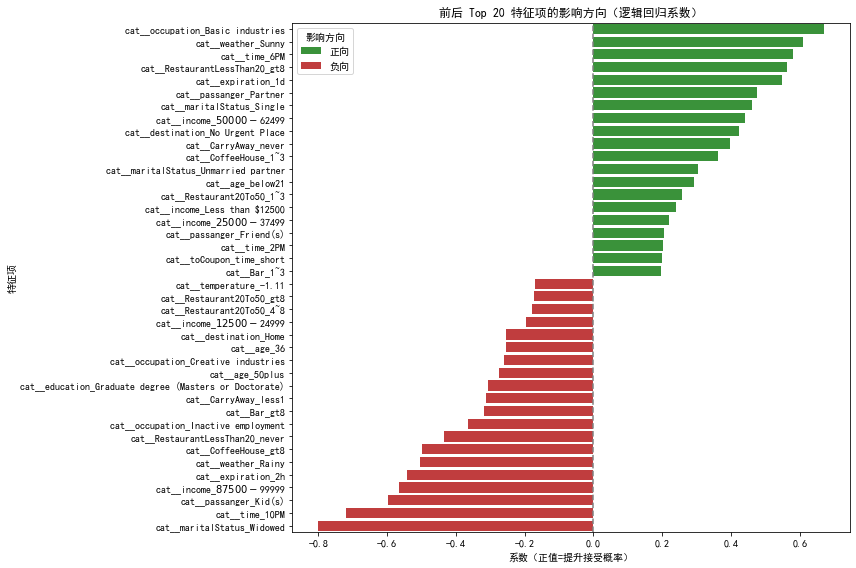


🔍 正在分析 coupon 类型：Coffee House

📊 模型评估报告：
              precision    recall  f1-score   support

           0     0.7105    0.7029    0.7067       377
           1     0.7136    0.7209    0.7172       387

    accuracy                         0.7120       764
   macro avg     0.7120    0.7119    0.7119       764
weighted avg     0.7120    0.7120    0.7120       764

Accuracy : 0.7120
Precision: 0.7136
Recall   : 0.7209

🎯 每个特征项对接收优惠券的影响方向（前部分）:
| feature                          |     coef | impact   |
|:---------------------------------|---------:|:---------|
| cat__CoffeeHouse_4~8             | 0.865419 | 正向     |
| cat__CoffeeHouse_gt8             | 0.811724 | 正向     |
| cat__CoffeeHouse_1~3             | 0.59709  | 正向     |
| cat__time_10AM                   | 0.542192 | 正向     |
| cat__Bar_never                   | 0.451208 | 正向     |
| cat__expiration_1d               | 0.420319 | 正向     |
| cat__RestaurantLessThan20_never  | 0.383214 | 正向     |
| cat__Restaurant20To50_gt8       

D:\Anaconda\data\lib\site-packages\pandas\compat\_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\data\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



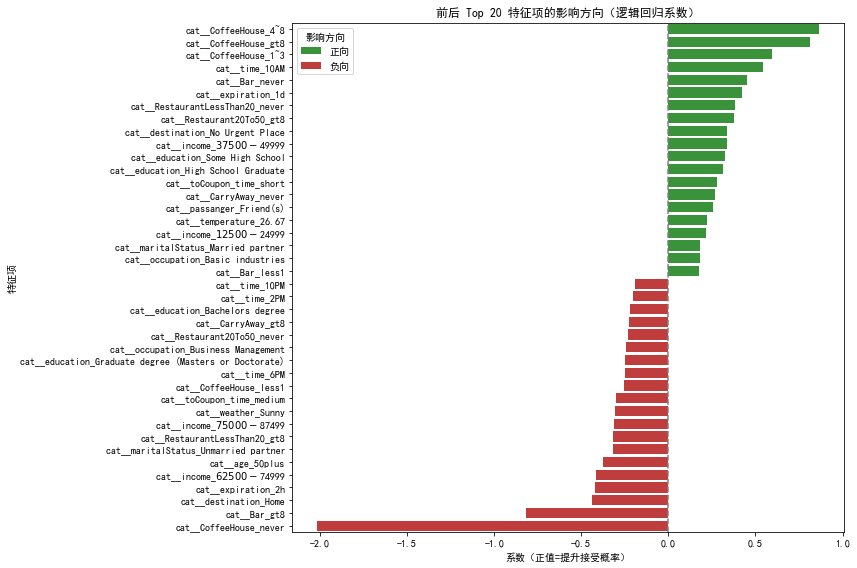


🔍 正在分析 coupon 类型：Bar

📊 模型评估报告：
              precision    recall  f1-score   support

           0     0.7339    0.7634    0.7484       224
           1     0.6467    0.6101    0.6278       159

    accuracy                         0.6997       383
   macro avg     0.6903    0.6867    0.6881       383
weighted avg     0.6977    0.6997    0.6983       383

Accuracy : 0.6997
Precision: 0.6467
Recall   : 0.6101

🎯 每个特征项对接收优惠券的影响方向（前部分）:
| feature                          |     coef | impact   |
|:---------------------------------|---------:|:---------|
| cat__Bar_4~8                     | 0.972616 | 正向     |
| cat__education_Some High School  | 0.937457 | 正向     |
| cat__RestaurantLessThan20_never  | 0.870637 | 正向     |
| cat__time_6PM                    | 0.827355 | 正向     |
| cat__maritalStatus_Widowed       | 0.743978 | 正向     |
| cat__passanger_Friend(s)         | 0.739878 | 正向     |
| cat__Bar_gt8                     | 0.564288 | 正向     |
| cat__weather_Sunny               | 0.5583

D:\Anaconda\data\lib\site-packages\pandas\compat\_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\data\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



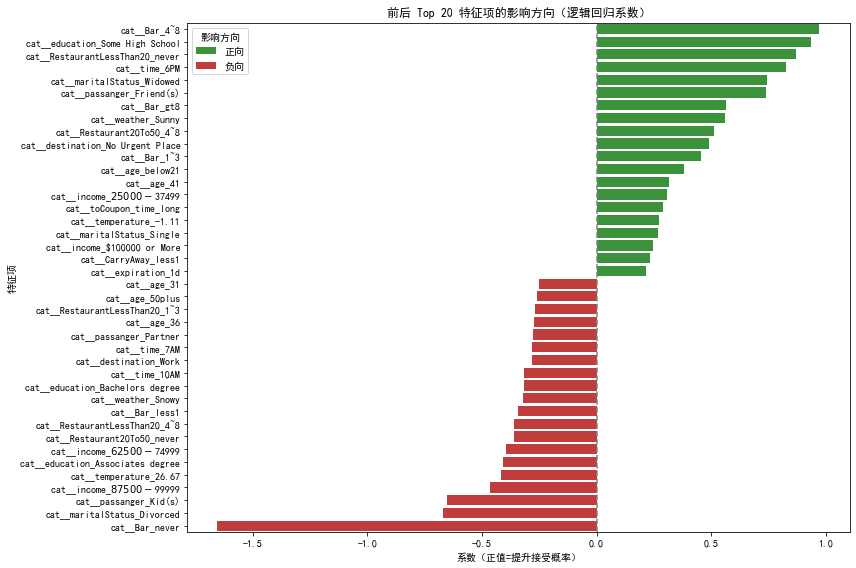


🔍 正在分析 coupon 类型：Carry out & Take away

📊 模型评估报告：
              precision    recall  f1-score   support

           0     0.6410    0.2000    0.3049       125
           1     0.7602    0.9577    0.8476       331

    accuracy                         0.7500       456
   macro avg     0.7006    0.5789    0.5762       456
weighted avg     0.7275    0.7500    0.6988       456

Accuracy : 0.7500
Precision: 0.7602
Recall   : 0.9577

🎯 每个特征项对接收优惠券的影响方向（前部分）:
| feature                          |     coef | impact   |
|:---------------------------------|---------:|:---------|
| cat__education_Some High School  | 0.885369 | 正向     |
| cat__destination_No Urgent Place | 0.626237 | 正向     |
| cat__RestaurantLessThan20_never  | 0.50682  | 正向     |
| cat__time_6PM                    | 0.493016 | 正向     |
| cat__occupation_Social service   | 0.473798 | 正向     |
| cat__time_2PM                    | 0.421682 | 正向     |
| cat__weather_Sunny               | 0.348808 | 正向     |
| cat__education_Associat

D:\Anaconda\data\lib\site-packages\pandas\compat\_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\data\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



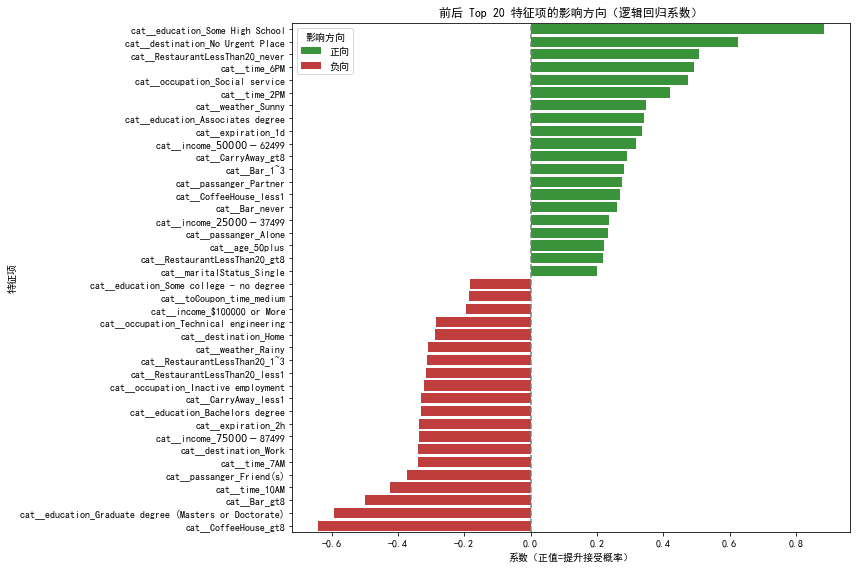


🔍 正在分析 coupon 类型：Restaurant(20-50)

📊 模型评估报告：
              precision    recall  f1-score   support

           0     0.6420    0.7584    0.6954       149
           1     0.6667    0.5333    0.5926       135

    accuracy                         0.6514       284
   macro avg     0.6544    0.6459    0.6440       284
weighted avg     0.6537    0.6514    0.6465       284

Accuracy : 0.6514
Precision: 0.6667
Recall   : 0.5333

🎯 每个特征项对接收优惠券的影响方向（前部分）:
| feature                               |     coef | impact   |
|:--------------------------------------|---------:|:---------|
| cat__passanger_Partner                | 0.642293 | 正向     |
| cat__Restaurant20To50_gt8             | 0.576134 | 正向     |
| cat__expiration_1d                    | 0.538053 | 正向     |
| cat__CoffeeHouse_1~3                  | 0.538004 | 正向     |
| cat__Restaurant20To50_4~8             | 0.507163 | 正向     |
| cat__occupation_Technical engineering | 0.486677 | 正向     |
| cat__income_$25000 - $37499           | 0.46

D:\Anaconda\data\lib\site-packages\pandas\compat\_optional.py:117: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

D:\Anaconda\data\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



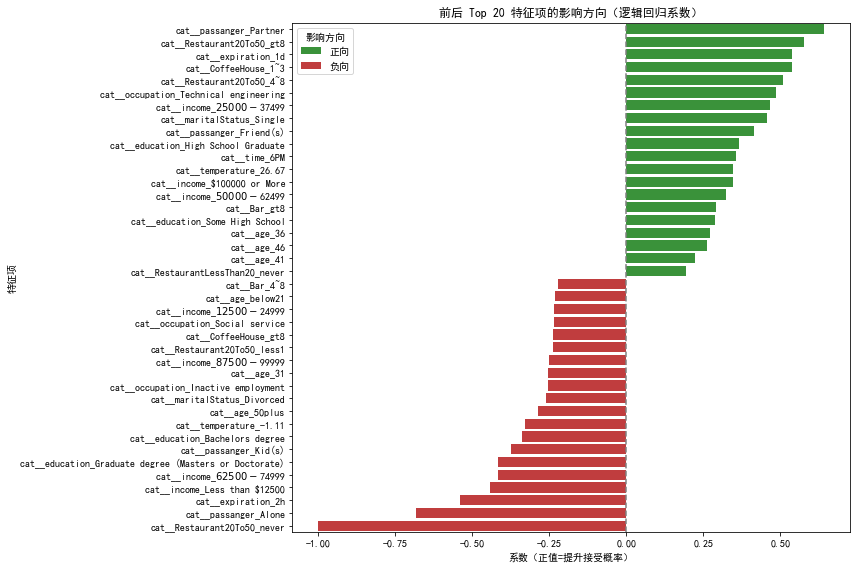

In [18]:
#找出针对不同类型消费的明显组合
types_features = ['destination',
'passanger',
'weather',
'temperature',
'time',
'expiration',
'gender',
'age',
'maritalStatus',
'has_children',
'education',
'occupation',
'income',
'Bar',
'CoffeeHouse',
'CarryAway',
'RestaurantLessThan20',
'Restaurant20To50',                  
'toCoupon_time'
]

# 分析不同 coupon 类型的影响因素
def analyze_by_coupon_type(data, coupon_types, feature_cols, target_col='Y', top_k=20):
    results = {}
    for coupon in coupon_types:
        print(f"\n{'='*60}\n🔍 正在分析 coupon 类型：{coupon}\n")
        
        # 筛选对应类型的数据
        data_coupon = data[data['coupon'] == coupon]
        data_coupon = data_coupon[feature_cols + [target_col]].dropna()

        if len(data_coupon) < 100:
            print(f"⚠️ 数据量过小（{len(df_coupon)} 条），跳过分析。")
            continue

        # 调用逻辑回归特征分析函数
        result = analyze_logistic_feature_impact(
            X=data_coupon[feature_cols],
            y=data_coupon[target_col],
            top_k=top_k
        )
        
        results[coupon] = result
    return results

# 分析所有类型的 coupon 的影响因素
coupon_types = data['coupon'].dropna().unique().tolist()
coupon_feature_results = analyze_by_coupon_type(
    data=data,
    coupon_types=coupon_types,
    feature_cols=types_features,
    target_col='Y',
    top_k=20
)

对于不同类型的都进行了分析，可以看出不同类型的消费场所影响特征有很大不同，因此后续推送优惠券时，如果有具体的针对某一类型消费场所提高，那么采用策略和对整体推送优惠券的策略又有不同。
同理需要时可筛选组合特征，针对性推送策略。可优化方向是，使用精度更高的算法并且对用户更多行为数据+偏好数据进行挖掘，当用户位置或者行程有变化时，可以实时推送针对性优惠券。当然具体实施时，要考虑用户体验、计算成本、合法合规等方面进行具体设计。
使用算法+大数据进行推荐后，数据分析复盘也是有必要的。同样对于指标变化需要明白why和what，才有可能制定出更有效的调整方向。

In [35]:
types_results = []

for coupon, df in coupon_feature_results.items():
    df['coupon'] = coupon  # 添加 coupon 类型
    types_results.append(df)

# 合并为一个 DataFrame
types_result_data = pd.concat(types_results, ignore_index=True)

# 保存为 Excel 文件（一个 sheet）
types_result_data.to_excel(r"D:\兼职\兼职\作品项目\types_result_data.xlsx", index=False)

distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


#### 对于有效性较低的用户&场景，提出针对性用户分群、场景触发、优惠券设计调整措施

bar:
1.  去酒吧次数少是重要负向因素，可结合正向因素，提出明显降低决策和消费成本的组合，推动用户形成消费习惯。
如：在晚上6点给年轻、单身人士推送大额优惠券；给常去客户推出带新客进店优惠券；
2. 高收入人士也是弱意向人群，可以针对性推送高消费酒吧场所优惠券
3. 公益从业者可以从社会责任角度推行一些优惠券：每消费1捐0.1

Carry out & Take away：
1. 咖啡、酒吧常客、带孩子人群、有朋友人群对于外带明显负向，可能用户更看重这些场所空间和社交属性：
a. 减少对外带优惠券推荐
b. 结合地理位置，对于等位时间较长的餐厅、公园游乐场等适合户外就餐的地点可结合高转化特征推送

Coffee House：
1. 时间上越早推送效果越好
2. 去咖啡店少+酒吧多是明显负向因素，可能因为两者使用时间有冲突，因此：
a. 互斥推送
b. 前一天早结束活跃+今日早活跃用户可结合正向特征推送

Restaurant(<20)：
1. 上午10点明显正向，下午6点明显正向，和Restaurant(20-50)的特征具有相似性。用户消费习惯更倾向于晚餐去餐馆消费，所以可以在晚上推送餐厅优惠券。
2. 高收入、常去Restaurant(20-50)的人群是弱意向客户，这部分人群可更多推送高价值消费场所优惠券

Restaurant(20-50)：
1. 未养成消费习惯和收入是影响因素，除了参考bar的策略，让用户养成消费习惯外，也要考虑客观情况，如：
a.在节假日、发薪日推送优惠券
b.和信用卡等联合绑定推送
